In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [8]:
#Import dataset
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [9]:
#Clean dataframe
data = data.rename(columns={"Sentence #": "Sentence"})
data.drop(['POS'], axis=1, inplace=True)
data["Tag"] = data["Tag"].str.upper()
data = data.fillna(method='ffill')
data.head()

,Sentence,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [37]:
#List of non-O unique tags
data['Tag'].unique()

array(['O', 'B-GEO', 'B-GPE', 'B-PER', 'I-GEO', 'B-ORG', 'I-ORG', 'B-TIM',
       'B-ART', 'I-ART', 'I-PER', 'I-GPE', 'I-TIM', 'B-NAT', 'B-EVE',
       'I-EVE', 'I-NAT'], dtype=object)

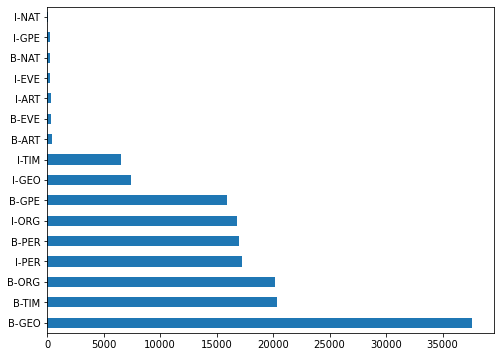

In [10]:
#Visualise distribution of unique non-O tags
plt.figure(figsize=(8, 6))
data.Tag[data.Tag != 'O']\
    .value_counts()\
    .plot\
    .barh();

In [11]:
#Retrive sentences and tags from dataset
class get_sentences(object):
    
    def __init__(self, data):
        self.sent = 1
        self.dataset = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                    s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
getter = get_sentences(data)
sentences = getter.sentences

In [12]:
#Compare raw and tagged sentences
raw_sentence = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
print("Raw sentence: {}".format(raw_sentence[27]))

print("Tagged sentence:" + "\n" + "\n".join(map(str, sentences[27])))

Raw sentence: SpaceShipOne was financed with more than $ 20 million from Paul Allen , a co-founder of the Microsoft Corporation .
Tagged sentence:
('SpaceShipOne', 'B-ART')
('was', 'O')
('financed', 'O')
('with', 'O')
('more', 'O')
('than', 'O')
('$', 'O')
('20', 'O')
('million', 'O')
('from', 'O')
('Paul', 'B-PER')
('Allen', 'I-PER')
(',', 'O')
('a', 'O')
('co-founder', 'O')
('of', 'O')
('the', 'O')
('Microsoft', 'B-ORG')
('Corporation', 'I-ORG')
('.', 'O')


In [13]:
#Define attributes
MAX_LEN = max([len(s) for s in sentences])
DIM_EMBEDDINGS = 50

In [14]:
#Map sentences and NER tags
from future.utils import iteritems

words = list(set(data["Word"].values))
number_words = len(words)

word2idx = {w: i+1 for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}

tags = list(set(data["Tag"].values))
number_tags = len(tags)

tag2idx = {t: i+1 for i, t in enumerate(tags)}
idx2tag = {i: w for w, i in iteritems(tag2idx)}

In [15]:
#Pad sequence data 
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post")
print(X)

[[34820  7807 18097 ...     0     0     0]
 [15548 30864  2813 ...     0     0     0]
 [22913 28180 18530 ...     0     0     0]
 ...
 [18752 23648  4377 ...     0     0     0]
 [25477 32458 28498 ...     0     0     0]
 [28155 18824  8459 ...     0     0     0]]


In [16]:
#Pad sequence data 
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post")

#One hot encode 
from tensorflow.keras.utils import to_categorical
y = [to_categorical(i, num_classes=number_tags+1) for i in y]

In [17]:
#Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
#Initialise model 
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, TimeDistributed, Bidirectional
from keras_contrib.layers import CRF

#Input layer
input = Input(shape=(MAX_LEN,))

#Embedding layer
model = Embedding(input_dim=number_words+1, 
                  input_length=MAX_LEN,
                  output_dim=DIM_EMBEDDINGS)(input)

#BiLSTM layer
model = Bidirectional(LSTM(units=DIM_EMBEDDINGS, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5))(model)
model = LSTM(units=DIM_EMBEDDINGS*2,
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5)(model)

#TimeDistributed layer
model = TimeDistributed(Dense(number_tags+1, activation="relu"))(model)

#CRF layer
crf = CRF(number_tags+1)  
out = crf(model)  

model = Model(input, out)

In [19]:
#Compile model 
model.compile(optimizer="rmsprop", 
              loss=crf.loss_function, 
              metrics=[crf.accuracy, "accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 104)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 100)          40400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 104, 100)          80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
_________________________________________________________________
crf_1 (CRF)                  (None, 104, 18)           702       
Total params: 1,882,270
Trainable params: 1,882,270
Non-trainable params: 0
_________________________________________________

In [20]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=10, validation_split=0.2, verbose=1)

Train on 30693 samples, validate on 7674 samples
Epoch 1/10
30693/30693 [==============================] - 323s 11ms/step - loss: 0.1162 - crf_viterbi_accuracy: 0.9680 - accuracy: 0.7900 - val_loss: 0.0399 - val_crf_viterbi_accuracy: 0.9829 - val_accuracy: 0.9829
Epoch 2/10
30693/30693 [==============================] - 289s 9ms/step - loss: 0.0262 - crf_viterbi_accuracy: 0.9860 - accuracy: 0.7900 - val_loss: 0.0141 - val_crf_viterbi_accuracy: 0.9882 - val_accuracy: 0.9882
Epoch 3/10
30693/30693 [==============================] - 475s 15ms/step - loss: 0.0083 - crf_viterbi_accuracy: 0.9881 - accuracy: 0.7900 - val_loss: 0.0015 - val_crf_viterbi_accuracy: 0.9889 - val_accuracy: 0.9889
Epoch 4/10
30693/30693 [==============================] - 337s 11ms/step - loss: -0.0053 - crf_viterbi_accuracy: 0.9895 - accuracy: 0.7900 - val_loss: -0.0104 - val_crf_viterbi_accuracy: 0.9894 - val_accuracy: 0.9894
Epoch 5/10
30693/30693 [==============================] - 319s 10ms/step - loss: -0.0171 -

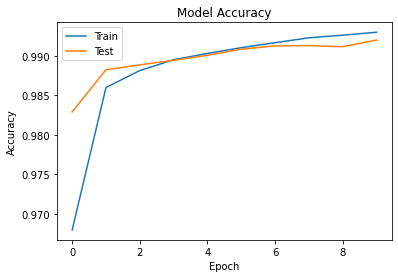

In [126]:
# Visualising model accuracy
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

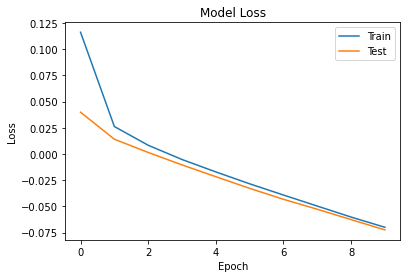

In [127]:
# Visualising model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [24]:
#Evaluating the model
from sklearn.metrics import classification_report
y_pred = model.predict(np.array(X_test))  
print(classification_report(np.argmax(y_test, 2).ravel(), 
                            np.argmax(y_pred, axis=2).ravel(),
                            labels=list(idx2tag.keys()), 
                            target_names=list(idx2tag.values())))

              precision    recall  f1-score   support

           O       0.99      0.99      0.99    177741
       I-NAT       0.00      0.00      0.00         8
       B-GEO       0.84      0.88      0.86      7593
       I-ART       0.00      0.00      0.00        57
       I-GPE       0.77      0.55      0.64        44
       I-EVE       0.00      0.00      0.00        63
       B-GPE       0.96      0.92      0.94      3146
       B-ORG       0.66      0.67      0.66      3953
       B-EVE       0.00      0.00      0.00        75
       B-ART       0.00      0.00      0.00        78
       B-NAT       0.00      0.00      0.00        40
       I-GEO       0.81      0.72      0.76      1474
       I-ORG       0.73      0.69      0.71      3319
       B-PER       0.80      0.80      0.80      3406
       I-TIM       0.83      0.66      0.74      1269
       I-PER       0.84      0.83      0.83      3575
       B-TIM       0.90      0.86      0.88      4052

   micro avg       0.96   

In [128]:
#Compare actual and predicted tags in a random sample
r = np.random.randint(0, X_test.shape[0])
y_rand = model.predict(np.array([X_test[r]]))
y_rand = np.argmax(y_rand, axis=-1)
y_true = np.argmax(np.array(y_test), axis=-1)[r]

print("{:15}{:5}\t{}".format("Word", "Actual", "Predicted"))
print("-"*35)

n = 0
for (w, t, pred) in zip(X_test[r], y_true, y_rand[0]):
    if n==20:
        break
    else:
        print("{:15}{}\t{}".format(words[w-1], tags[t], tags[pred]))
        n+=1

Word           Actual	Predicted
-----------------------------------
Russia         I-ART	I-ART
is             I-NAT	I-NAT
voicing        I-NAT	I-NAT
surprise       I-NAT	I-NAT
at             I-NAT	I-NAT
the            I-NAT	I-NAT
White          B-EVE	B-EVE
House          B-PER	B-PER
move           I-NAT	I-NAT
to             I-NAT	I-NAT
withdraw       I-NAT	I-NAT
a              I-NAT	I-NAT
bilateral      I-NAT	I-NAT
civilian       I-NAT	I-NAT
nuclear        I-NAT	I-NAT
cooperation    I-NAT	I-NAT
agreement      I-NAT	I-NAT
from           I-NAT	I-NAT
consideration  I-NAT	I-NAT
by             I-NAT	I-NAT


In [129]:
#Save model
import pickle
with open('word_to_index.pickle', 'wb') as f:
    pickle.dump(word2idx, f)

with open('tag_to_index.pickle', 'wb') as f:
    pickle.dump(tag2idx, f)